In [1]:
import airline
import environment

import os
import ray
from ray import air, tune
from ray import tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.ddpg import DDPGConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.env import PettingZooEnv
from ray.tune.registry import register_env
import multiprocessing
from ray.rllib.algorithms.dqn import DQN

import numpy as np


2023-10-06 01:42:26,497	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
2023-10-06 01:42:26,565	WARNING deprecation.py:50 -- DeprecationWarning: `build_tf_policy` has been deprecated. This will raise an error in the future!
2023-10-06 01:42:26,567	WARNING deprecation.py:50 -- DeprecationWarning: `build_policy_class` has been deprecated. This will raise an error in the future!


In [2]:
def simulate(n=300, action=airline.DEFAULT_POLICY):
    dfs = airline.get_df()
    print(airline.CONFIG)
    sim = airline.Simulator(airline.CONFIG, dfs, add_flights=True, save_history=True)

    actions = {x:action for x in sim.airports}
    # for i in range(30000):
    for i in range(n):
        sim.step()
    return sim.history

In [3]:
# from ray.rllib.algorithms.algorithm import Algorithm
# from ray.rllib.algorithms.simple_q import SimpleQConfig
# from ray.rllib.utils.checkpoints import convert_to_msgpack_checkpoint
# checkpoint = "./ray_results/airline/DQN/DQN_airline_d22b8_00000_0_2023-10-05_10-16-33/checkpoint_000008"
# checkpoint_msgpack = "./ray_results/airline/msgpack"
# convert_to_msgpack_checkpoint(checkpoint, checkpoint_msgpack)

def load_agent(checkpoint = "./ray_results/airline/DQN/DQN_airline_d22b8_00000_0_2023-10-05_10-16-33/checkpoint_000008"):
    ray.shutdown()
    ray.init()

    cfg = airline.CONFIG
    sim_days = 30
    cfg["num_iters"] = sim_days * 24 * 60 // cfg["timestep"]
    def env_creator(cfg):
        # env = environment.env(cfg, render_mode="human")
        env = environment.env(cfg, render_mode=None)
        env.reset(seed=42)
        return PettingZooEnv(env)
    env_name = "airline"
    register_env(env_name, env_creator)

    env = env_creator(cfg)
    obs_space = env.observation_space
    act_space = env.action_space
    policies = {agent_id:(None, obs_space, act_space, {}) for agent_id in env.get_agent_ids()}

    n_workers = int(0.8*multiprocessing.cpu_count())
    config = (
        DQNConfig()
        .environment(
            env=env_name, 
            env_config=cfg,
            )
        # .training(gamma=0.9, lr=0.01)
        .training(train_batch_size=n_workers*len(policies))
        .rollouts(num_rollout_workers=n_workers, rollout_fragment_length=len(policies))
        .multi_agent(
            policies=policies,
            policy_mapping_fn=(lambda agent_id, *args, **kwargs: agent_id),      
            )
        .resources(num_gpus=int(os.environ.get("RLLIB_NUM_GPUS", "0")))
        .debugging(
            log_level="ERROR"
            # log_level="DEBUG"
        ) 
        .framework(framework="torch")
    )

    agent = DQN(config=config)
    agent.restore(checkpoint)
    return agent

In [10]:
def simulate_with_agent(agent, n=300):
    cfg = airline.CONFIG
    dfs = airline.get_df()
    print(airline.CONFIG)
    sim = airline.Simulator(airline.CONFIG, dfs, add_flights=True, save_history=True)

    # for i in range(30000):
    for i in range(n):
        for icao in cfg['agent_airports']:
            sim.airports[icao].policy = agent.compute_single_action(
                observation=sim.airports[icao].observe(),
                state=[sim.airports[icao].policy],
                policy_id = icao,
            )
        sim.step()
    return sim.history

In [5]:
def chart(history):
    import pandas as pd
    data = { 
        i:{
            **{k:x[k] for k in ["incoming_count","incoming_delay","outgoing_count","outgoing_delay","policy"]},
            "landed_count":{k : len(v) for k,v in x["landed"].items()},
            "landed_delay":{k : sum(max(0,y["takeoff_ready"]-y["takeoff_plan"]) for y in v.values()) for k,v in x["landed"].items()},
        }
        for i, x in history.items() if (i != "current")
    }
    df = pd.Series({(k,kk,kkk):vvv for k,v in data.items() for kk, vv in v.items() for kkk, vvv in vv.items()}).unstack()

    df_RKSI = df["RKSI"].unstack()
    df_RKSI["policy"].plot()
    # (df_RKSI[["landed_delay"]].divide(df_RKSI[["landed_count"]].values+0.01)).plot()
    (df_RKSI[["incoming_delay","outgoing_delay"]].diff(6*24).divide(df_RKSI[["incoming_count","outgoing_count"]].diff(6*24).values+0.01)).plot()

{'std_delay': 10, 'buffer_time': 10, 'late_threshold': 15, 'holding_period': 120, 'timestep': 10, 'capacity': 10, 'num_plane': 100, 'num_iters': 30000, 'agent_airports': ['RKSI', 'RKSS', 'RKPK', 'RKPC', 'RKTN', 'RKTU', 'RKJB'], 'debug': False}


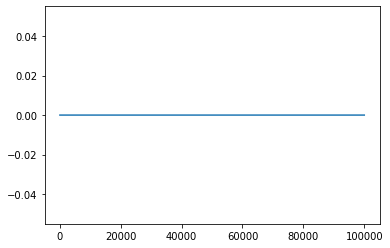

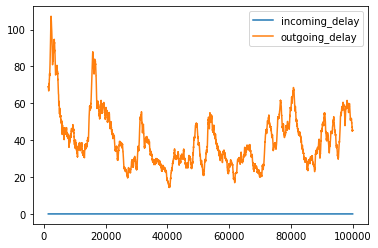

In [6]:
chart(simulate(n=10000, action=0))

{'std_delay': 10, 'buffer_time': 10, 'late_threshold': 15, 'holding_period': 120, 'timestep': 10, 'capacity': 10, 'num_plane': 100, 'num_iters': 30000, 'agent_airports': ['RKSI', 'RKSS', 'RKPK', 'RKPC', 'RKTN', 'RKTU', 'RKJB'], 'debug': False}


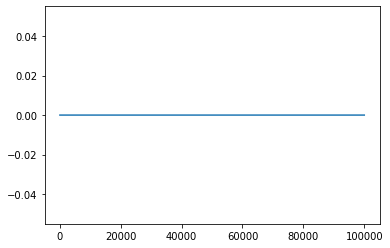

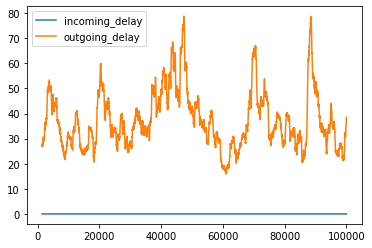

In [7]:
chart(simulate(n=10000, action=1))

{'std_delay': 10, 'buffer_time': 10, 'late_threshold': 15, 'holding_period': 120, 'timestep': 10, 'capacity': 10, 'num_plane': 100, 'num_iters': 30000, 'agent_airports': ['RKSI', 'RKSS', 'RKPK', 'RKPC', 'RKTN', 'RKTU', 'RKJB'], 'debug': False}


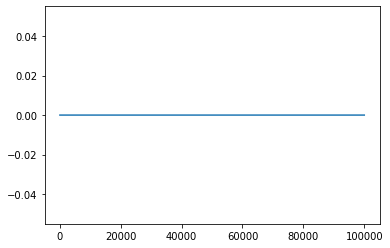

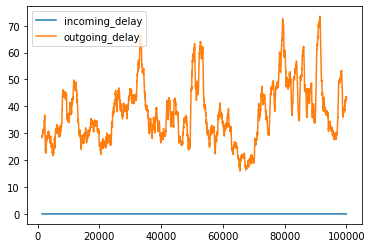

In [8]:
chart(simulate(n=10000, action=2))

2023-10-06 01:46:09,064	INFO worker.py:1642 -- Started a local Ray instance.
/home/jongkook90/anaconda3/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/jongkook90/anaconda3/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/jongkook90/anaconda3/lib/python3.9/site-packages/ray/tune/logge

{'std_delay': 10, 'buffer_time': 10, 'late_threshold': 15, 'holding_period': 120, 'timestep': 10, 'capacity': 10, 'num_plane': 100, 'num_iters': 4320, 'agent_airports': ['RKSI', 'RKSS', 'RKPK', 'RKPC', 'RKTN', 'RKTU', 'RKJB'], 'debug': False}


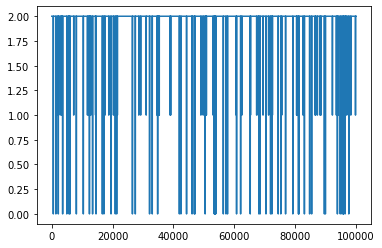

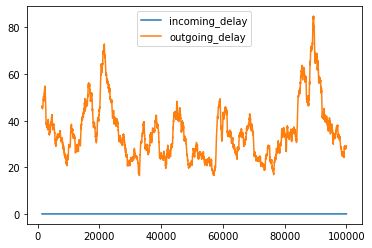

In [11]:
agent = load_agent()
chart(simulate_with_agent(agent, n=10000))